# Блок импортов

In [ ]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.3-py3-none-any.whl size=190251 sha256=902e581344e208ea132b077a589d8f02a03c3f2e4edc01518c0a9795774d6bc0
  Stored in directory: /root/.cache/pip/wheels/05/f8/db/124d43bec122d6ec0ab3713fadfe25ebed8af52ec561682b4e
Successfully built pyod


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import OneClassSVM, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
from scipy.stats import norm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.cluster import DBSCAN, SpectralClustering, KMeans
from sklearn.mixture import GaussianMixture
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min
from pyod.models.hbos import HBOS

# Загрузка датасета

Первый датасет — данные по весу и росту в зависимости от пола. В нем нет разметки, поэтому необходимо использовать методы обучения без учителя.

Импортируем датасет и визуально посмотрим на него перед началом работы:

In [ ]:
weight_height = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/weight-height.csv')
weight_height.head(10)

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801
5,Male,67.253016,152.212156
6,Male,68.785081,183.927889
7,Male,68.348516,167.971110
8,Male,67.018950,175.929440
9,Male,63.456494,156.399676


С учетом чисел в данных вес измеряется в фунтах, а рост в дюймах, поэтому не стоит удивляться что число обозначающее вес больше чем число, обозначающее рост. Хотя у нас все по другому

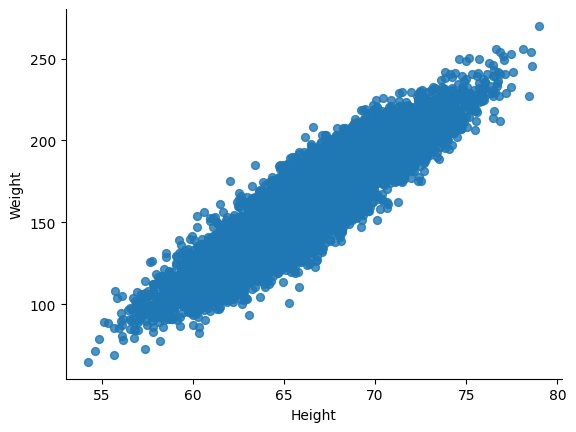

In [ ]:
weight_height.plot(kind='scatter', x='Height', y='Weight', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

На этом графике который озаглавливает домашенее задание мы четко видим, что существует прямая положительная зависимость между ростом и весом. Чем больше рост, тем как правило больше и вес.

Ну создадим копию исходного набора данных и поехали

In [ ]:
df1 = weight_height.copy()

Почему то мне кажется тут есть ошибка сразу

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gender  10000 non-null  object 
 1   Height  10000 non-null  float64
 2   Weight  10000 non-null  float64
dtypes: float64(2), object(1)
memory usage: 234.5+ KB


Отлично у нас 10 000 строк пропусков и дубликотов нет, можно работать

# Задание 1.

Сравнение моделей обучения без учителя (4 балла)
Используя разные алгоритмы машинного обучения, проанализируйте наш датасет на наличие выбросов и аномалий. В качестве переменных для анализа используйте только вес и рост.

Создайте поле из 6 графиков. Каждый график (scatter plot) должен иметь заголовок, названия полей, прозрачность точек 0.8. Должны отсутствовать рамки со всех сторон. Пометьте аномалии красным цветом, а все остальные данные — зеленым.

Поместите на графики следующие 6 алгоритмов:

* Interquartile range (IQR) — возьмите выбросы по x и y.
* Isolation forest.
* Local Outlier Factor.
* One-class SVM.
* Gaussian Mixture.
* DBSCAN.
Напишите, какие модели показали себя лучше всего и почему.

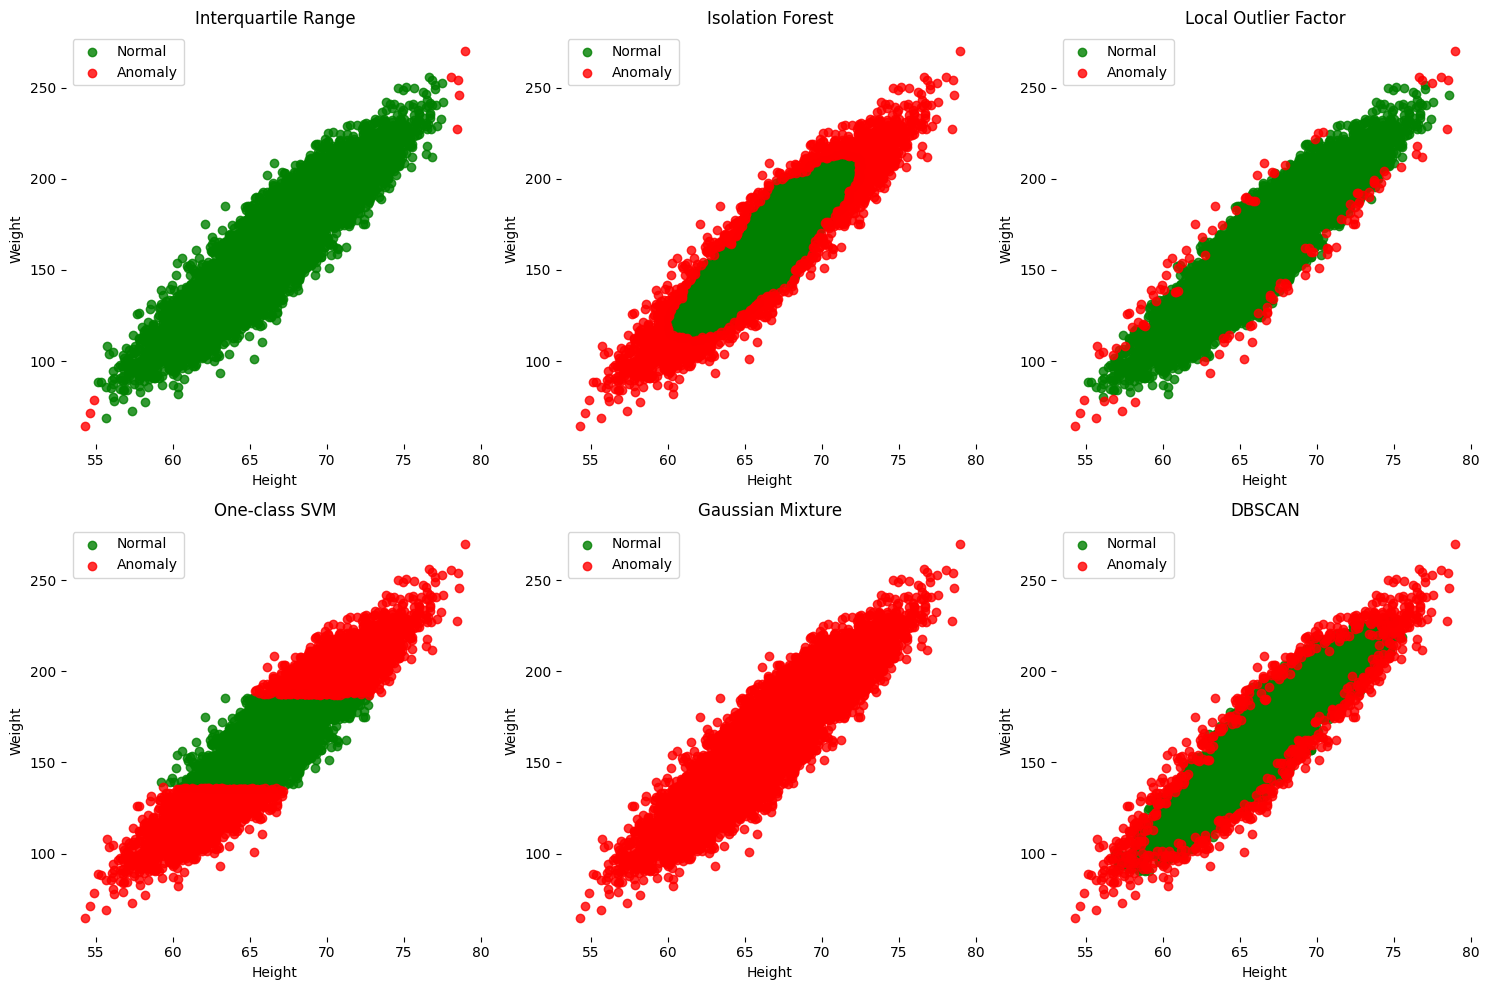

In [ ]:
# Берем только 2 признака как сказано в задании, ну так то их 2 и есть всего
features = df1[['Height', 'Weight']]

# Опишем наши модели. Важно тут все модели инициируются без указания гиперпараметров
models = {
    "Interquartile Range": None,  # IQR - будет рассчитано позже
    "Isolation Forest": IsolationForest(random_state=42),
    "Local Outlier Factor": LocalOutlierFactor(),
    "One-class SVM": OneClassSVM(),
    "Gaussian Mixture": GaussianMixture(),
    "DBSCAN": DBSCAN()
}

# Определение аномалий для каждой модели
for name, model in models.items():
    if name == "Interquartile Range":
        Q1 = features.quantile(0.25)
        Q3 = features.quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((features < (Q1 - 1.5 * IQR)) | (features > (Q3 + 1.5 * IQR))).any(axis=1)
    elif name == "Gaussian Mixture":
        outliers = model.fit_predict(features) == 0 # вот тут логика совсем другая ниже я покажу как с этим можно играть
    else:
        outliers = model.fit_predict(features) == -1
    models[name] = outliers

# Создание графиков
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, (name, outlier) in enumerate(models.items()):
    ax = axs[i // 3, i % 3]
    ax.scatter(features.loc[~outlier, 'Height'], features.loc[~outlier, 'Weight'], color='green', alpha=0.8, label='Normal')
    ax.scatter(features.loc[outlier, 'Height'], features.loc[outlier, 'Weight'], color='red', alpha=0.8, label='Anomaly')
    ax.set_title(name)
    ax.set_xlabel('Height')
    ax.set_ylabel('Weight')
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

Что же давайте попробуем описать то что мы увидели на графиках.

* 1) Метод интерквартильного размаха нашел точки по x и y которые выходят за пределы 1,5 * IQR и тем самым показал как аномалии очень высоких и очень низких людей,  атак же очень тяжелыъ и очень легких. СО всей очевидностью в большинстве случаев точки стали аномалиями как по x так и по y, но не в этом суть - метод очень прост вычислительно, он способен показать значимую статистику, я думаю никто не поспорит что черезмерно высоких (толстых) как и нихких и худых в обществе (да и в медицине) принято считать аномалиями
* 2) Изолирующий лес аккуратно выбрал самую середину в форме элепса - обозначив ее как нормальные значения, остальные же определив в аномалии. Тем самым изолирующий лес выступил за устреднение - нормальное это то что в центре
* 3) Очень интересно отработотал LOF (на мой взгляд это лучший алгоритм без учителя). Он не только признал аномалиями черезмерно высоких, низких, худых и толстых, он еще и определил в аномалии те точки где вес сильно выше или сильно ниже средних для этого роста (а так впроде и определяется индлекс массы тела). Так что вывод LOF очень хорош.
* 4) Гиперплоскость одноклассовой векторной машины безаппеляционно решила, что нормальность это вес от где-то 140 фунтов до 180, рост при этом не важен. Ну что же это в какой то мере тоже есть мера среднего и она имеет право на существование
* 5) Знаменитая модель Gaussian Mixture повела себя очень неожиданно - записала все в аномалии (если бы мы поменяли класс на 1 то все бы были нормальными). Причина на мой взгляд проста. Эта модель любить когда ей говорят сколько у нас классов. В этой ситуации она находит только 1 класс
* 6) DBSCAN по результату очень похож на LOF. Он работает вокруг плотнисти точек, нам где точки раположены плотно он определяет их как нормальные, а все что немного отстоит от "плотной" группы как аномалии. От личии от LOF мы видим, что в аномалии попало больше точек.    

Важно подчеркнуть что нет идеального решения и каждый алгоритм необходимо и выбирать и настраивать под текущую задачу. А теперь запустим тот же самый код но добавим в алгортмы основные гиперпарметры и посмотрим как с их помощью мы можем поменять результаты работы модели. И собственно подтвердим указанный выше тезис

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


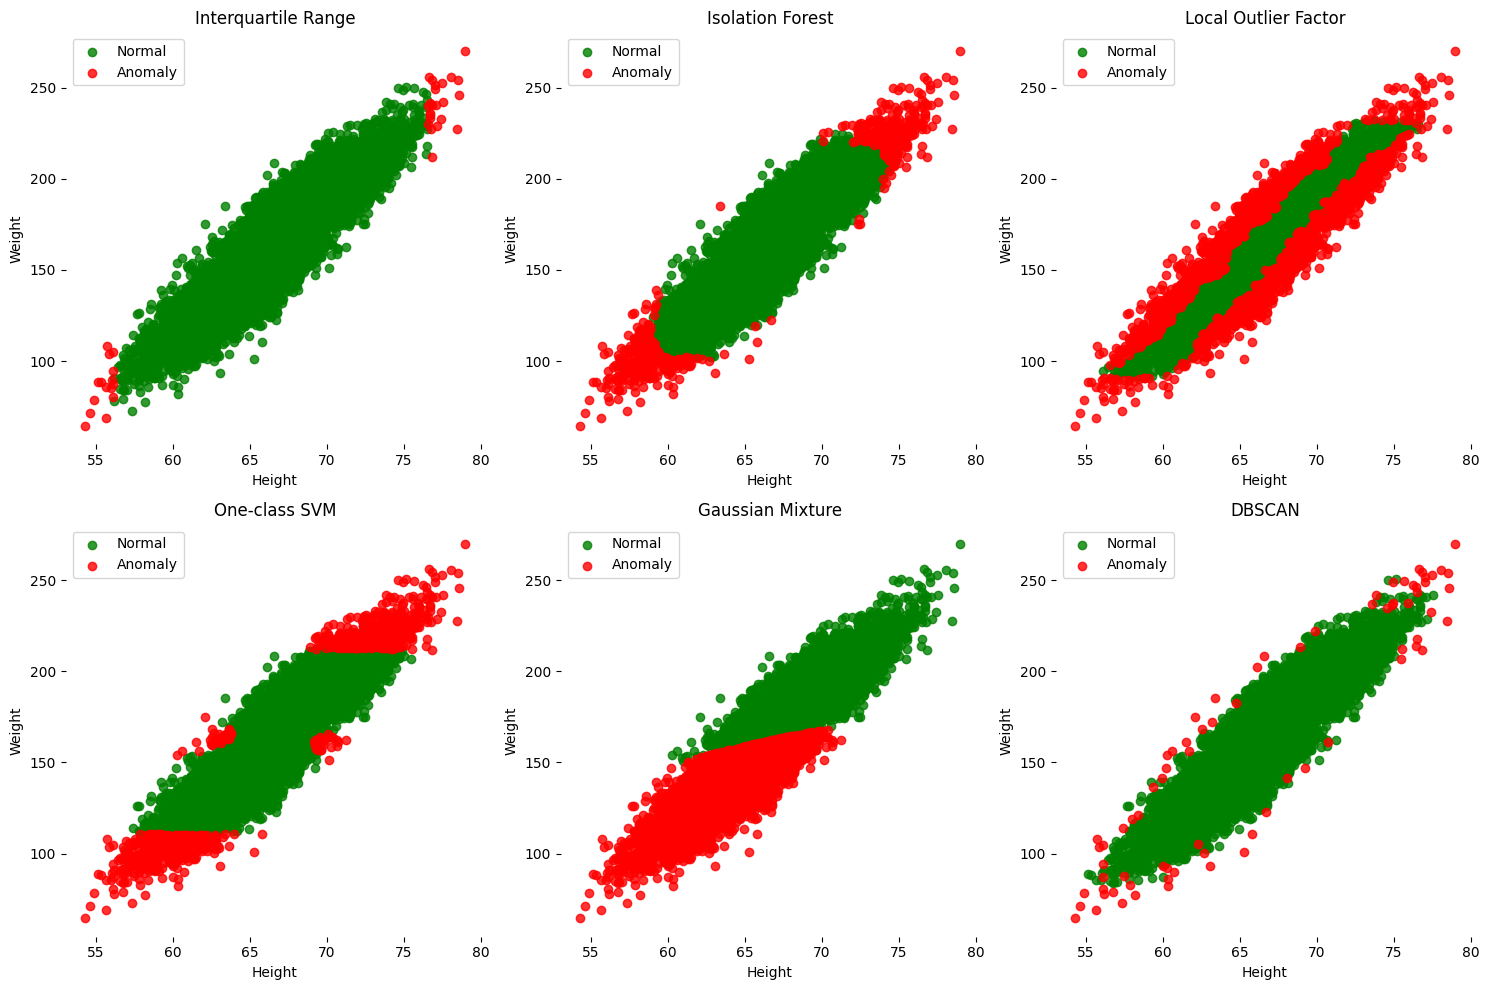

In [ ]:
# Выделение признаков для анализа
features = df1[['Height', 'Weight']]

# Определение моделей с основными гиперпараметрами
models = {
    "Interquartile Range": None,  # IQR - будет рассчитано позже
    "Isolation Forest": IsolationForest(n_estimators=100, contamination=0.06, random_state=42),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=50, contamination=0.2),
    "One-class SVM": OneClassSVM(nu=0.1),
    "Gaussian Mixture": GaussianMixture(n_components=2, covariance_type='full', random_state=42),
    "DBSCAN": DBSCAN(eps=0.9, min_samples=2)
}

# Определение аномалий для каждой модели
for name, model in models.items():
    if name == "Interquartile Range":
        Q1 = features.quantile(0.25)
        Q3 = features.quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((features < (Q1 - 1.3 * IQR)) | (features > (Q3 + 1.3 * IQR))).any(axis=1)
    elif name == "Gaussian Mixture":
        outliers = model.fit_predict(features) == 0
    else:
        outliers = model.fit_predict(features) == -1
    models[name] = outliers

# Создание графиков
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, (name, outlier) in enumerate(models.items()):
    ax = axs[i // 3, i % 3]
    ax.scatter(features.loc[~outlier, 'Height'], features.loc[~outlier, 'Weight'], color='green', alpha=0.8, label='Normal')
    ax.scatter(features.loc[outlier, 'Height'], features.loc[outlier, 'Weight'], color='red', alpha=0.8, label='Anomaly')
    ax.set_title(name)
    ax.set_xlabel('Height')
    ax.set_ylabel('Weight')
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

Мы чуть чуть изменили подход к интерквартильному размаху, добавили гиперпараметры в модели и вот мы видим уже несколько иную картину. Обратим внимание на метод Gaussian Mixture, мы попросили его разбить даннные на 2 класса и вот мы видим что уже не все точки он отнес к аномалиям. Для LOF и DBSACAN мы за счет гиперпараметров получили результаты как в первом случае только поменяв их местами. А в случае с LOF еще и удалось сформировать из них довольно прямую линию "нормальности"

# Задания 2 и 3

Используя датасет, определите оптимальные параметры модели Isolation Forest с помощью кросс-валидации.

Наш датасет — это набор данных, первоначально взятый из набора данных UCI о заболеваниях щитовидной железы. Он содержит 16 категориальных атрибутов, 5 числовых атрибутов и 1 целевой атрибут. Всего — 22 атрибута.

In [ ]:
thyroid = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/annthyroid_unsupervised_anomaly_detection.csv', sep=';').iloc[:, :-2]
thyroid.head()

,Age,Sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3_measured,TT4_measured,T4U_measured,FTI_measured,Outlier_label
0,0.45,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,61.0,6.0,23.0,87.0,26.0,o
1,0.61,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,29.0,15.0,61.0,96.0,64.0,o
2,0.16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,29.0,19.0,58.0,103.0,56.0,o
3,0.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,114.0,3.0,24.0,61.0,39.0,o
4,0.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,49.0,3.0,5.0,116.0,4.0,o


In [ ]:
thyroid.columns

Index(['Age', 'Sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH', 'T3_measured',
       'TT4_measured', 'T4U_measured', 'FTI_measured', 'Outlier_label '],
      dtype='object')

In [ ]:
df2 = thyroid.copy()

In [ ]:
# Преобразование меток в бинарные значения (1 для нормальных наблюдений, -1 для аномалий) - это может потом понадобиться для визуализаиций
y_true = np.where(df2['Outlier_label '] == 'n', 1, -1)

Задание 2.

Проверка влияния параметров Isolation Forest на итоговые параметры (3 балла)
После обучения модели выполните следующее:

Обучите модель Isolation Forest на данных Х с использованием найденных оптимальных параметров (для этого оберните Isolation Forest в sklearn.model_selection.GridSearchCV). В GridSearchCV используйте params = {'n_estimators': list(range(5, 15)), 'max_features': list(range(2, 10))}.
Сделайте предсказания на данных Х.
Поиграйте с параметром n_jobs — создайте 6 разных визуализаций с параметрами от 1 до 6.
Замените значения предсказаний, где 1 соответствует «нормальному» наблюдению (normal), а -1 — «выбросу» (outlier).
Выведите лучшие параметры модели Isolation Forest для всех 6 параметров (для лучшего понимания оформите выводы).

In [ ]:
# дополнительно импортируем GridSearchCV - именно он отберет лучшие параметры
from sklearn.model_selection import GridSearchCV

In [ ]:
# посмотрим на столбец с метками
df2.describe(include='object')

,Outlier_label
count,6916
unique,2
top,n
freq,6666


Так так мы видим сильный перекос в сторону нормальных значений - это нормально, поэтому мы попросим наш жадный поиск ориентироваться на метрику f1, это стандартная практика для работы с несбалансированными наборами данных

In [ ]:
# Замена значений "n" на 1 и "o" на -1 в столбце "Outlier_label" - по сути по нему мы будем определять какие параметры лучше подходят
df2['Outlier_label '] = df2['Outlier_label '].replace({'n': 1, 'o': -1})

In [ ]:
# И Да мы выберем F1 как наиболее сбалансированную метрику, нам важно правильно определять и нормальные и аномальные значения
from sklearn.metrics import f1_score, make_scorer

In [ ]:
# Определение параметров для GridSearchCV
params = {'n_estimators': list(range(5, 15)), 'max_features': list(range(2, 10))}

# Создание модели Isolation Forest
model = IsolationForest(random_state=42)

# Создание объекта GridSearchCV
grid_search = GridSearchCV(model, param_grid=params, scoring='f1')

# Обучение модели
grid_search.fit(df2.drop(columns=['Outlier_label ']), df2['Outlier_label '])

# Получение лучших параметров модели
best_params = grid_search.best_params_

# Вывод лучших параметров модели
print(f'Best parameters for Isolation Forest: {best_params}')


Best parameters for Isolation Forest: {'max_features': 6, 'n_estimators': 13}


In [ ]:
df2['Outlier_label '].value_counts()

 1    6666
-1     250
Name: Outlier_label , dtype: int64

In [ ]:
from sklearn.metrics import confusion_matrix

Из личных наблюдений алгоритм IF очень интересный он уникален тем что он пригоден и для определения выбросов и для определения новизны, при этом он может принимать как маркированные данные так и нет(в некоторых случаях от этого зависит результат - забегая вперед скажу что тут такого не получилось и результат как на маркированных так и на немаркированных одинковые). Используем все эти 3 варианта обучения с лучшими параметрами

In [ ]:
# Создание модели Isolation Forest с лучшими параметрами
model = IsolationForest(**best_params, random_state=42)

# Обучение модели на всех данных
model.fit(df2.drop(columns=['Outlier_label ']), df2['Outlier_label '])
# Предсказания на всех данных
predictions_all = model.predict(df2.drop(columns=['Outlier_label ']))

# Предсказания на когда учим только на данных X
model.fit(df2.drop(columns=['Outlier_label ']))
predictions_X = model.predict(df2.drop(columns=['Outlier_label ']))

# Предсказания на нормальных данных (где Outlier_label = 1)
normal_indices = df2[df2['Outlier_label '] == 1].index
X_normal = df2.loc[normal_indices]
X_normal = X_normal.drop(columns=['Outlier_label '])

model.fit(X_normal)
predictions_normal = model.predict(df2.drop(columns=['Outlier_label ']))

confusion_matrix_all = confusion_matrix(df2['Outlier_label '], predictions_all, labels=[1, -1])
confusion_matrix_X = confusion_matrix(df2['Outlier_label '], predictions_X, labels=[1, -1])
confusion_matrix_normal = confusion_matrix(df2['Outlier_label '], predictions_normal, labels=[1, -1])

# Вывод матриц ошибок
print("Confusion matrix for all data:")
print(confusion_matrix_all)
print("\nConfusion matrix for X:")
print(confusion_matrix_X)
print("\nConfusion matrix for normal data:")
print(confusion_matrix_normal)


Confusion matrix for all data:
[[6323  343]
 [ 173   77]]

Confusion matrix for X:
[[6323  343]
 [ 173   77]]

Confusion matrix for normal data:
[[6319  347]
 [ 148  102]]


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

А теперь вызуализируем это

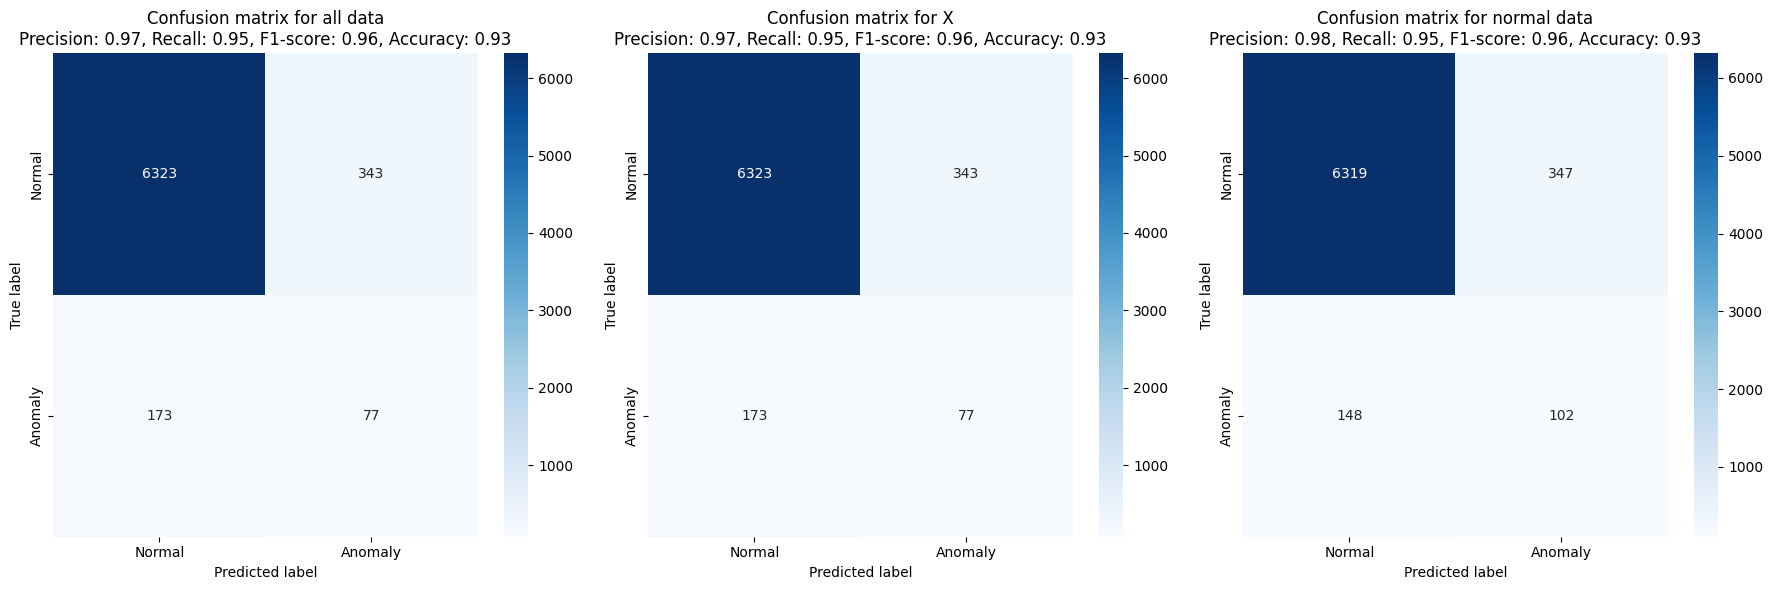

In [ ]:
# Вычисление метрик для всех данных
precision_all = precision_score(df2['Outlier_label '], predictions_all)
recall_all = recall_score(df2['Outlier_label '], predictions_all)
f1_all = f1_score(df2['Outlier_label '], predictions_all)
accuracy_all = accuracy_score(df2['Outlier_label '], predictions_all)

# Вычисление метрик для данных X
precision_X = precision_score(df2['Outlier_label '], predictions_X)
recall_X = recall_score(df2['Outlier_label '], predictions_X)
f1_X = f1_score(df2['Outlier_label '], predictions_X)
accuracy_X = accuracy_score(df2['Outlier_label '], predictions_X)

# Вычисление метрик для нормальных данных
precision_normal = precision_score(df2['Outlier_label '], predictions_normal)
recall_normal = recall_score(df2['Outlier_label '], predictions_normal)
f1_normal = f1_score(df2['Outlier_label '], predictions_normal)
accuracy_normal = accuracy_score(df2['Outlier_label '], predictions_normal)

# Создание сетки для отображения трех тепловых карт в одной строке
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Визуализация матрицы ошибок для всех данных
sns.heatmap(confusion_matrix_all, annot=True, cmap='Blues', fmt='g', ax=axes[0])
axes[0].set_title(f"Confusion matrix for all data\nPrecision: {precision_all:.2f}, Recall: {recall_all:.2f}, F1-score: {f1_all:.2f}, Accuracy: {accuracy_all:.2f}")
axes[0].set_xlabel("Predicted label")
axes[0].set_ylabel("True label")
axes[0].set_xticklabels(['Normal', 'Anomaly'])
axes[0].set_yticklabels(['Normal', 'Anomaly'])

# Визуализация матрицы ошибок для данных X
sns.heatmap(confusion_matrix_X, annot=True, cmap='Blues', fmt='g', ax=axes[1])
axes[1].set_title(f"Confusion matrix for X\nPrecision: {precision_X:.2f}, Recall: {recall_X:.2f}, F1-score: {f1_X:.2f}, Accuracy: {accuracy_X:.2f}")
axes[1].set_xlabel("Predicted label")
axes[1].set_ylabel("True label")
axes[1].set_xticklabels(['Normal', 'Anomaly'])
axes[1].set_yticklabels(['Normal', 'Anomaly'])

# Визуализация матрицы ошибок для нормальных данных
sns.heatmap(confusion_matrix_normal, annot=True, cmap='Blues', fmt='g', ax=axes[2])
axes[2].set_title(f"Confusion matrix for normal data\nPrecision: {precision_normal:.2f}, Recall: {recall_normal:.2f}, F1-score: {f1_normal:.2f}, Accuracy: {accuracy_normal:.2f}")
axes[2].set_xlabel("Predicted label")
axes[2].set_ylabel("True label")
axes[2].set_xticklabels(['Normal', 'Anomaly'])
axes[2].set_yticklabels(['Normal', 'Anomaly'])

plt.tight_layout()
plt.show()

Мы вимдим что все модели отработали более менее одинаково, но последний вариант обученный только на номальных данных (это определение новизны) в части выявления аномалий отработал в разы лучше, он меньше ошибся в части TP (если аномалии считать позитивом) и в части FN.

А теперь покажем, что наши параметры реально подобраны неплохо.Пример с кастомными параметрами на автомате

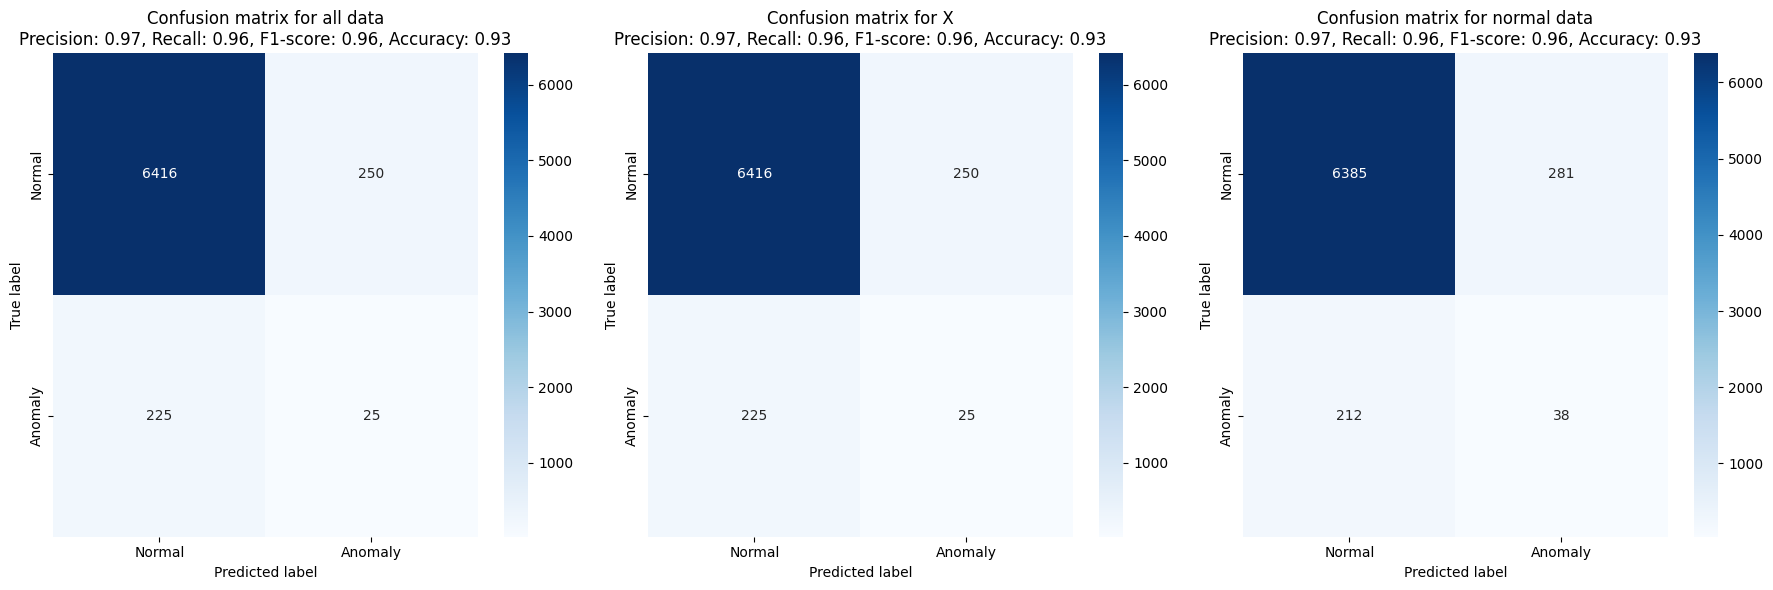

In [ ]:
# Произвольно заданные гиперпараметры
custom_params = {'n_estimators': 100, 'max_samples': 'auto', 'contamination': 'auto'}

# Создание модели Isolation Forest с произвольными гиперпараметрами
model = IsolationForest(**custom_params, random_state=42)

# Обучение модели на всех данных
model.fit(df2.drop(columns=['Outlier_label ']), df2['Outlier_label '])
# Предсказания на всех данных
predictions_all = model.predict(df2.drop(columns=['Outlier_label ']))

# Предсказания на когда учим только на данных X
model.fit(df2.drop(columns=['Outlier_label ']))
predictions_X = model.predict(df2.drop(columns=['Outlier_label ']))

# Предсказания на нормальных данных (где Outlier_label = 1)
normal_indices = df2[df2['Outlier_label '] == 1].index
X_normal = df2.loc[normal_indices]
X_normal = X_normal.drop(columns=['Outlier_label '])

model.fit(X_normal)
predictions_normal = model.predict(df2.drop(columns=['Outlier_label ']))

confusion_matrix_all = confusion_matrix(df2['Outlier_label '], predictions_all, labels=[1, -1])
confusion_matrix_X = confusion_matrix(df2['Outlier_label '], predictions_X, labels=[1, -1])
confusion_matrix_normal = confusion_matrix(df2['Outlier_label '], predictions_normal, labels=[1, -1])

# Вычисление метрик для всех данных
precision_all = precision_score(df2['Outlier_label '], predictions_all)
recall_all = recall_score(df2['Outlier_label '], predictions_all)
f1_all = f1_score(df2['Outlier_label '], predictions_all)
accuracy_all = accuracy_score(df2['Outlier_label '], predictions_all)

# Вычисление метрик для данных X
precision_X = precision_score(df2['Outlier_label '], predictions_X)
recall_X = recall_score(df2['Outlier_label '], predictions_X)
f1_X = f1_score(df2['Outlier_label '], predictions_X)
accuracy_X = accuracy_score(df2['Outlier_label '], predictions_X)

# Вычисление метрик для нормальных данных
precision_normal = precision_score(df2['Outlier_label '], predictions_normal)
recall_normal = recall_score(df2['Outlier_label '], predictions_normal)
f1_normal = f1_score(df2['Outlier_label '], predictions_normal)
accuracy_normal = accuracy_score(df2['Outlier_label '], predictions_normal)

# Создание сетки для отображения трех тепловых карт в одной строке
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Визуализация матрицы ошибок для всех данных
sns.heatmap(confusion_matrix_all, annot=True, cmap='Blues', fmt='g', ax=axes[0])
axes[0].set_title(f"Confusion matrix for all data\nPrecision: {precision_all:.2f}, Recall: {recall_all:.2f}, F1-score: {f1_all:.2f}, Accuracy: {accuracy_all:.2f}")
axes[0].set_xlabel("Predicted label")
axes[0].set_ylabel("True label")
axes[0].set_xticklabels(['Normal', 'Anomaly'])
axes[0].set_yticklabels(['Normal', 'Anomaly'])

# Визуализация матрицы ошибок для данных X
sns.heatmap(confusion_matrix_X, annot=True, cmap='Blues', fmt='g', ax=axes[1])
axes[1].set_title(f"Confusion matrix for X\nPrecision: {precision_X:.2f}, Recall: {recall_X:.2f}, F1-score: {f1_X:.2f}, Accuracy: {accuracy_X:.2f}")
axes[1].set_xlabel("Predicted label")
axes[1].set_ylabel("True label")
axes[1].set_xticklabels(['Normal', 'Anomaly'])
axes[1].set_yticklabels(['Normal', 'Anomaly'])

# Визуализация матрицы ошибок для нормальных данных
sns.heatmap(confusion_matrix_normal, annot=True, cmap='Blues', fmt='g', ax=axes[2])
axes[2].set_title(f"Confusion matrix for normal data\nPrecision: {precision_normal:.2f}, Recall: {recall_normal:.2f}, F1-score: {f1_normal:.2f}, Accuracy: {accuracy_normal:.2f}")
axes[2].set_xlabel("Predicted label")
axes[2].set_ylabel("True label")
axes[2].set_xticklabels(['Normal', 'Anomaly'])
axes[2].set_yticklabels(['Normal', 'Anomaly'])

plt.tight_layout()
plt.show()


Мы видим и по метриками и по числам в матрице ошибок что наш результат сущесвтенно хуже, пусть по метрикам этого как будто не видно, но числа они говорят сами за себя - с подогнанными значениями мы выявили гораздо больше аномалий, значить жадный поиск свое дело сделал и сделал хорошо и это победа

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import time

Так теперь перходим к n_jobs. Сразу отмечу что этот параметр определяет поточкность работы, то есть он распределяет работу алгоритма на разные потоки и по идее должен отрабатьвать не лучше а быстрее, ну посморим на это все

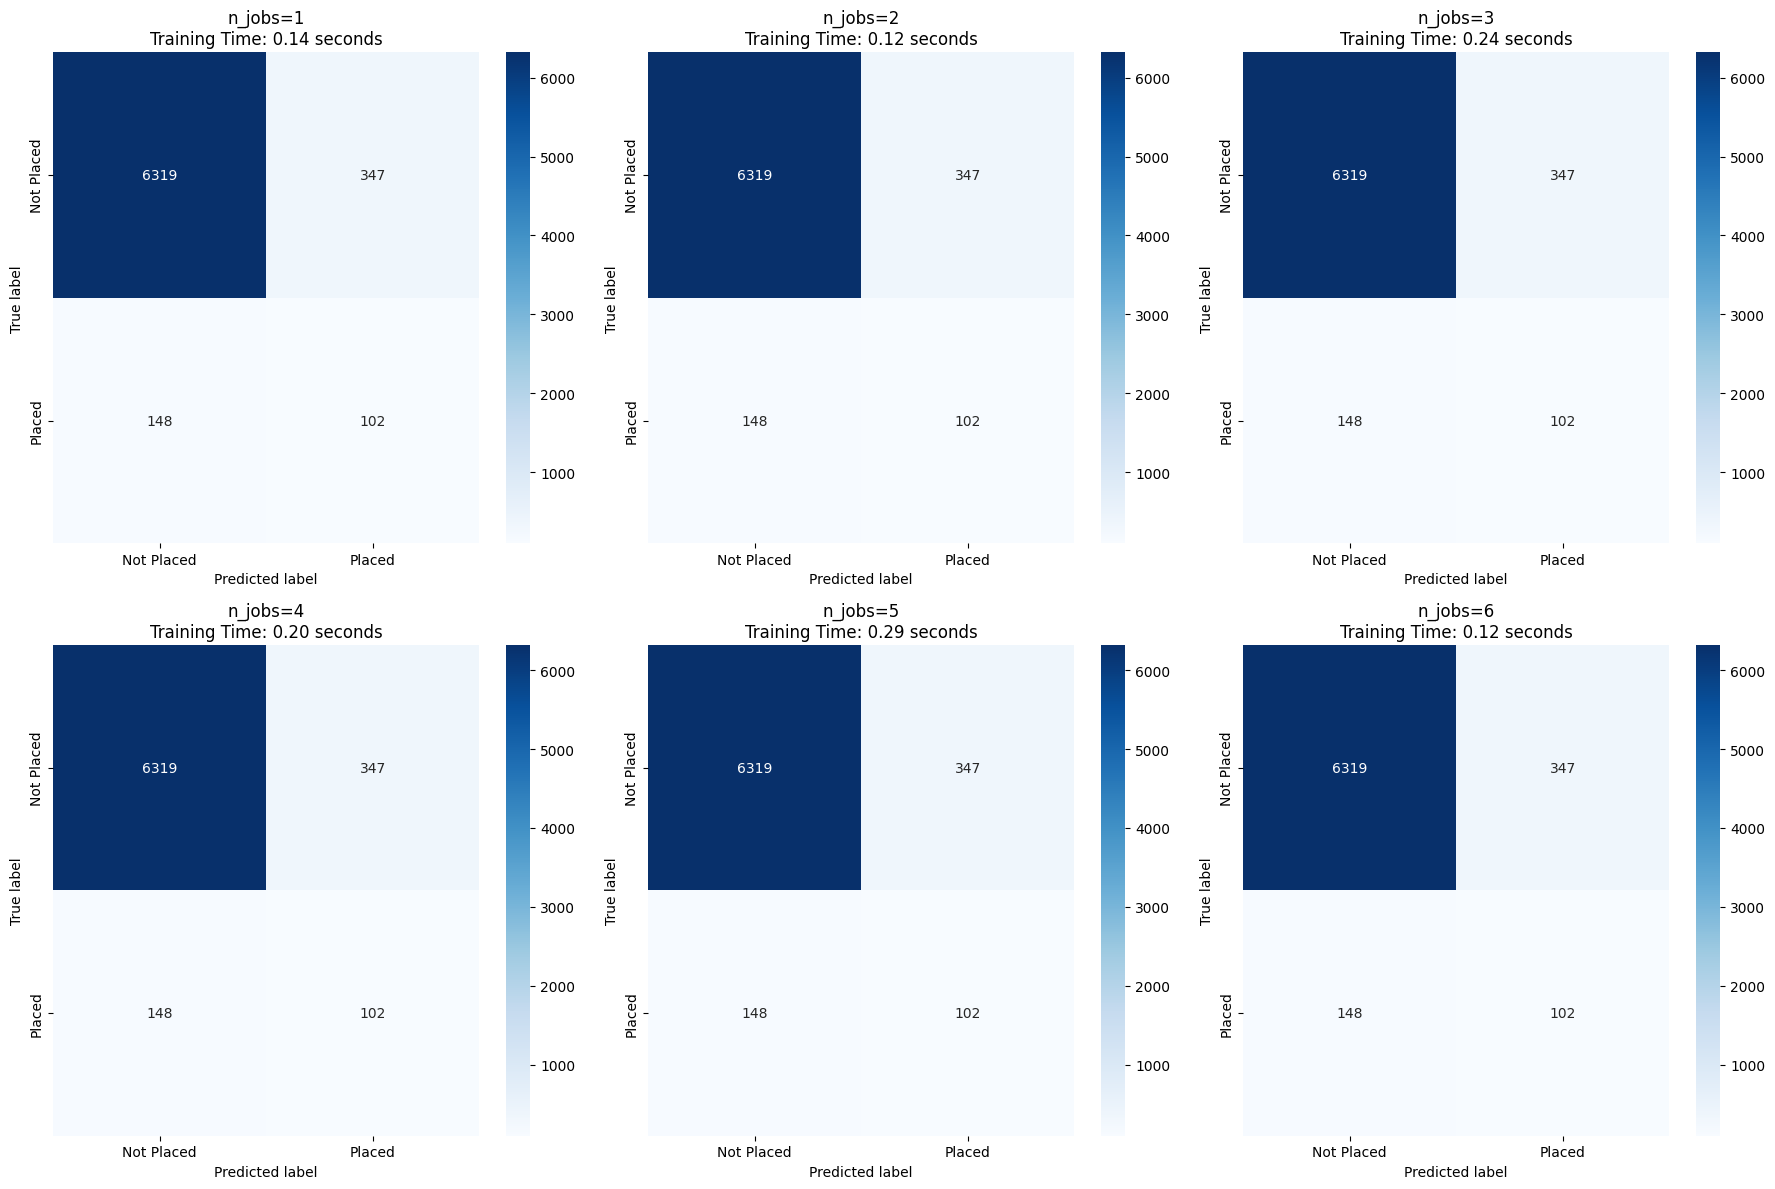

In [ ]:
# Инициализация значений n_jobs для Isolation Forest
n_jobs_values = [1, 2, 3, 4, 5, 6]

# Создание графиков
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for n_jobs, ax in zip(n_jobs_values, axes.flatten()):
    # Создание модели Isolation Forest с текущим значением n_jobs
    model = IsolationForest(n_jobs=n_jobs, random_state=42, **best_params)

    # Замер времени обучения модели
    start_time = time.time()
    # Предсказания на нормальных данных (где Outlier_label = 1)
    normal_indices = df2[df2['Outlier_label '] == 1].index
    X_normal = df2.loc[normal_indices]
    X_normal = X_normal.drop(columns=['Outlier_label '])

    model.fit(X_normal)
    predictions_normal = model.predict(df2.drop(columns=['Outlier_label ']))

    end_time = time.time()
    training_time = end_time - start_time


    # Вычисление матрицы ошибок
    confusion_matrix_normal = confusion_matrix(df2['Outlier_label '], predictions_normal, labels=[1, -1])

    # Визуализация матрицы ошибок
    sns.heatmap(confusion_matrix_normal, annot=True, cmap='Blues', fmt='g', ax=ax)
    ax.set_title(f"n_jobs={n_jobs}\nTraining Time: {training_time:.2f} seconds")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticklabels(['Not Placed', 'Placed'])
    ax.set_yticklabels(['Not Placed', 'Placed'])

plt.tight_layout()
plt.show()

Очень странно получилось, как мы и ожидали метрики работы алгоримов не изменились, но вот время оно сработало как то странно (причем я запускал несколько раз). Быстрее всего алгоритм отрабатывает когда у нас 1-2 джобы, потом рост до 20-24 секунд и к 6 джодам спад. Честно как это объяснитья не знаю, задание выполнил с параметром поиграл.

Задание 3.

Визуализация ROC-кривой в зависимости от параметров Isolation Forest (3 балла)
Для каждого Isolation Forest создайте отдельную roc_curve и полотно с шестью графиками для визуализации шести ROC-кривых в зависимости от параметра n_jobs.

В название каждого графика выведите F1-score, Precision и Recall для каждой модели Isolation Forest.

Приступая к этому заданию я знал, что метрики и лучшие параметры никак не изменятся, поэтому просто построил кривую, сначала на одном графике а потом и на 6 все ожидаемо оказалось одинаковым.

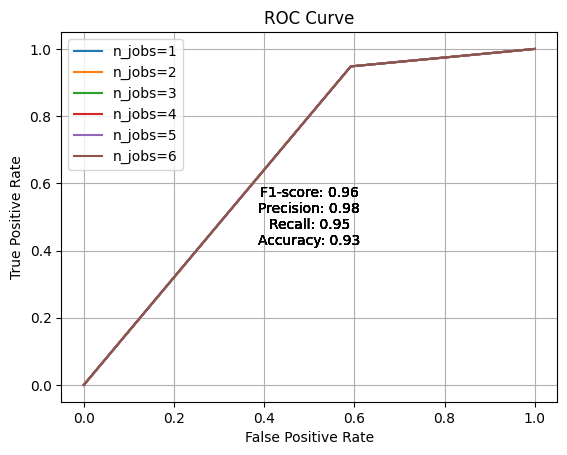

Metrics for n_jobs=1: {'f1': 0.9623086880377675, 'precision': 0.9771145817225916, 'recall': 0.9479447944794479, 'accuracy': 0.9284268363215732}
Best parametres n_jobs = 1 : {'max_features': 6, 'n_estimators': 13}
Metrics for n_jobs=2: {'f1': 0.9623086880377675, 'precision': 0.9771145817225916, 'recall': 0.9479447944794479, 'accuracy': 0.9284268363215732}
Best parametres n_jobs = 2 : {'max_features': 6, 'n_estimators': 13}
Metrics for n_jobs=3: {'f1': 0.9623086880377675, 'precision': 0.9771145817225916, 'recall': 0.9479447944794479, 'accuracy': 0.9284268363215732}
Best parametres n_jobs = 3 : {'max_features': 6, 'n_estimators': 13}
Metrics for n_jobs=4: {'f1': 0.9623086880377675, 'precision': 0.9771145817225916, 'recall': 0.9479447944794479, 'accuracy': 0.9284268363215732}
Best parametres n_jobs = 4 : {'max_features': 6, 'n_estimators': 13}
Metrics for n_jobs=5: {'f1': 0.9623086880377675, 'precision': 0.9771145817225916, 'recall': 0.9479447944794479, 'accuracy': 0.9284268363215732}
Best

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Создание списка значений для параметра n_jobs
n_jobs_values = list(range(1, 7))

# Создание пустого словаря для хранения результатов метрик
metrics_dict = {}

# Перебор значений параметра n_jobs
for n_jobs in n_jobs_values:
    # Создание модели Isolation Forest с текущим значением n_jobs
    model = IsolationForest(n_jobs=n_jobs, **best_params, random_state=42)

    normal_indices = df2[df2['Outlier_label '] == 1].index
    X_normal = df2.loc[normal_indices]
    X_normal = X_normal.drop(columns=['Outlier_label '])

    model.fit(X_normal)
    predictions_normal = model.predict(df2.drop(columns=['Outlier_label ']))

    # Вычисление метрик
    f1 = f1_score(df2['Outlier_label '], predictions_normal)
    precision = precision_score(df2['Outlier_label '], predictions_normal)
    recall = recall_score(df2['Outlier_label '], predictions_normal)
    accuracy = accuracy_score(df2['Outlier_label '], predictions_normal)

    # Сохранение метрик в словарь
    metrics_dict[n_jobs] = {'f1': f1, 'precision': precision, 'recall': recall, 'accuracy' : accuracy}

    # Расчет ROC-кривой
    fpr, tpr, _ = roc_curve(df2['Outlier_label '], predictions_normal)

    # Вывод ROC-кривой
    plt.plot(fpr, tpr, label=f'n_jobs={n_jobs}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)

    # Вывод метрик в заголовок графика
    plt.text(0.5, 0.5, f'F1-score: {f1:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nAccuracy: {accuracy:.2f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.show()

# Вывод метрик для каждого значения n_jobs
for n_jobs, metrics in metrics_dict.items():
    print(f'Metrics for n_jobs={n_jobs}: {metrics}')
    print(f'Best parametres n_jobs = {n_jobs} : {best_params}')


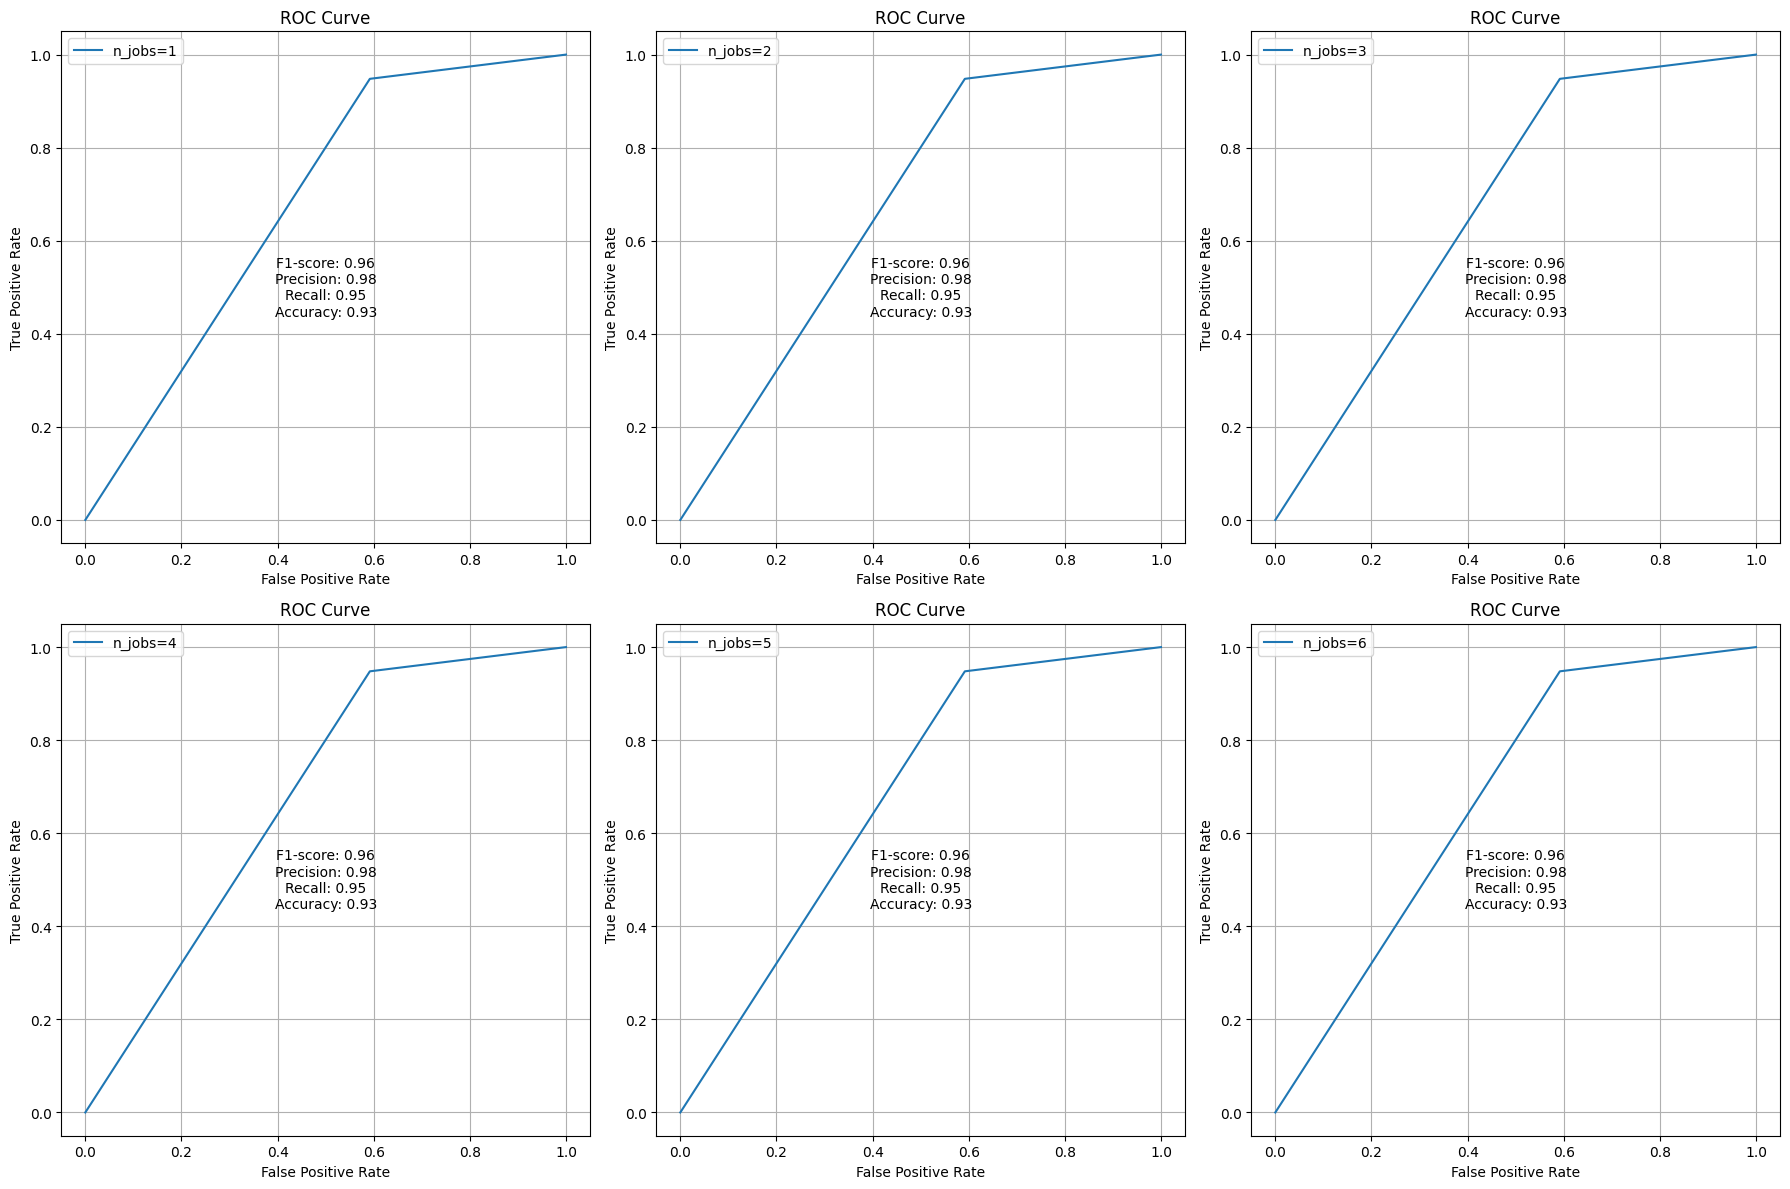

Metrics for n_jobs=1: {'f1': 0.9623086880377675, 'precision': 0.9771145817225916, 'recall': 0.9479447944794479, 'accuracy': 0.9284268363215732}
Best parametres n_jobs = 1 : {'max_features': 6, 'n_estimators': 13}
Metrics for n_jobs=2: {'f1': 0.9623086880377675, 'precision': 0.9771145817225916, 'recall': 0.9479447944794479, 'accuracy': 0.9284268363215732}
Best parametres n_jobs = 2 : {'max_features': 6, 'n_estimators': 13}
Metrics for n_jobs=3: {'f1': 0.9623086880377675, 'precision': 0.9771145817225916, 'recall': 0.9479447944794479, 'accuracy': 0.9284268363215732}
Best parametres n_jobs = 3 : {'max_features': 6, 'n_estimators': 13}
Metrics for n_jobs=4: {'f1': 0.9623086880377675, 'precision': 0.9771145817225916, 'recall': 0.9479447944794479, 'accuracy': 0.9284268363215732}
Best parametres n_jobs = 4 : {'max_features': 6, 'n_estimators': 13}
Metrics for n_jobs=5: {'f1': 0.9623086880377675, 'precision': 0.9771145817225916, 'recall': 0.9479447944794479, 'accuracy': 0.9284268363215732}
Best

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Создание списка значений для параметра n_jobs
n_jobs_values = list(range(1, 7))

# Создание пустого словаря для хранения результатов метрик
metrics_dict = {}

# Создание сетки для графиков
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Перебор значений параметра n_jobs
for n_jobs, ax in zip(n_jobs_values, axes.flatten()):
    # Создание модели Isolation Forest с текущим значением n_jobs
    model = IsolationForest(n_jobs=n_jobs, **best_params, random_state=42)

    normal_indices = df2[df2['Outlier_label '] == 1].index
    X_normal = df2.loc[normal_indices]
    X_normal = X_normal.drop(columns=['Outlier_label '])

    model.fit(X_normal)
    predictions_normal = model.predict(df2.drop(columns=['Outlier_label ']))

    # Вычисление метрик
    f1 = f1_score(df2['Outlier_label '], predictions_normal)
    precision = precision_score(df2['Outlier_label '], predictions_normal)
    recall = recall_score(df2['Outlier_label '], predictions_normal)
    accuracy = accuracy_score(df2['Outlier_label '], predictions_normal)

    # Сохранение метрик в словарь
    metrics_dict[n_jobs] = {'f1': f1, 'precision': precision, 'recall': recall, 'accuracy' : accuracy}

    # Расчет ROC-кривой
    fpr, tpr, _ = roc_curve(df2['Outlier_label '], predictions_normal)

    # Вывод ROC-кривой
    ax.plot(fpr, tpr, label=f'n_jobs={n_jobs}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend()
    ax.grid(True)

    # Вывод метрик в заголовок графика
    ax.text(0.5, 0.5, f'F1-score: {f1:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nAccuracy: {accuracy:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

# Вывод метрик для каждого значения n_jobs
for n_jobs, metrics in metrics_dict.items():
    print(f'Metrics for n_jobs={n_jobs}: {metrics}')
    print(f'Best parametres n_jobs = {n_jobs} : {best_params}')


Мне сложно сделать какие либо выводы, когда нет никакой динамики - очевидно я не так понял задание. Готов его переделать при поступлении разъяснений

Задание 4.

Проверка эффективности моделей учителем (4 балла)
Ранее мы обсуждали, что методы обучения с учителем можно использовать не только для поиска аномалий, но и для классической классификации. Аналогично первому заданию, используя разные алгоритмы обучения с учителем, постройте модель для классификации по данным датасета.

Наш третий датасет — данные по принятым и не принятым в университет студентам в зависимости от их среднего балла и балла за экзамен. В качестве переменных для анализа используйте средний балл (cgpa) и балл за экзамен (placement_exam_marks), а в качестве зависимой переменной в кластеризации используйте переменную placed.

Создайте поле из шести графиков. Каждый график должен представлять собой confusion_matrix (heatmap или тепловую карту) с попаданиями модели (матрица 2 на 2 с попаданиями модели, как делали на третьей неделе). Каждый график должен иметь заголовок и названия полей. На тепловой карте на каждом квадратике должно быть указано число, а также colorbar с правой стороны.

Поместите на графики следующие 6 алгоритмов:

* k-Nearest Neighbors (KNN);
* SVM (Support Vector Machine);
* Random Forest;
* AdaBoost;
* Gradient Boosting;
* Decision Tree.

In [52]:
placement = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/placement.csv')
placement.head()


,cgpa,placement_exam_marks,placed
0,7.19,26.0,1
1,7.46,38.0,1
2,7.54,40.0,1
3,6.42,8.0,1
4,7.23,17.0,0


In [53]:
df3 = placement.copy()

Сначала посмотрим на данные

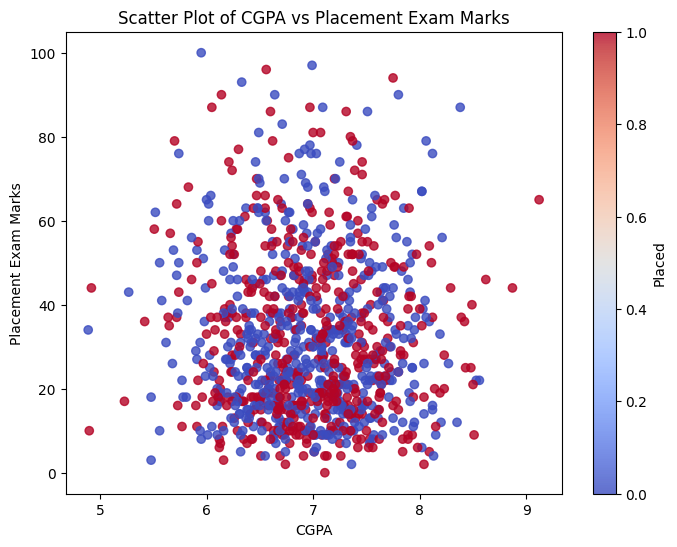

In [54]:
# Создание scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df3['cgpa'], df3['placement_exam_marks'], c=df3['placed'], cmap='coolwarm', alpha=0.8)
plt.xlabel('CGPA')
plt.ylabel('Placement Exam Marks')
plt.title('Scatter Plot of CGPA vs Placement Exam Marks')
plt.colorbar(label='Placed')
plt.show()

Здесь мы вилим первородный хаос, думаб что разобраться с ним алгоритмам будет черезвычайно сложно

Для начала проведем классическое исследование с разбиением на обучающую и тествую выборки

In [55]:
df3 = pd.DataFrame(placement)

# Разделение данных на признаки (X) и целевую переменную (y)
X = df3[['cgpa', 'placement_exam_marks']]
y = df3['placed']

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Размер обучающего набора:", X_train.shape)
print("Размер тестового набора:", X_test.shape)

Размер обучающего набора: (800, 2)
Размер тестового набора: (200, 2)


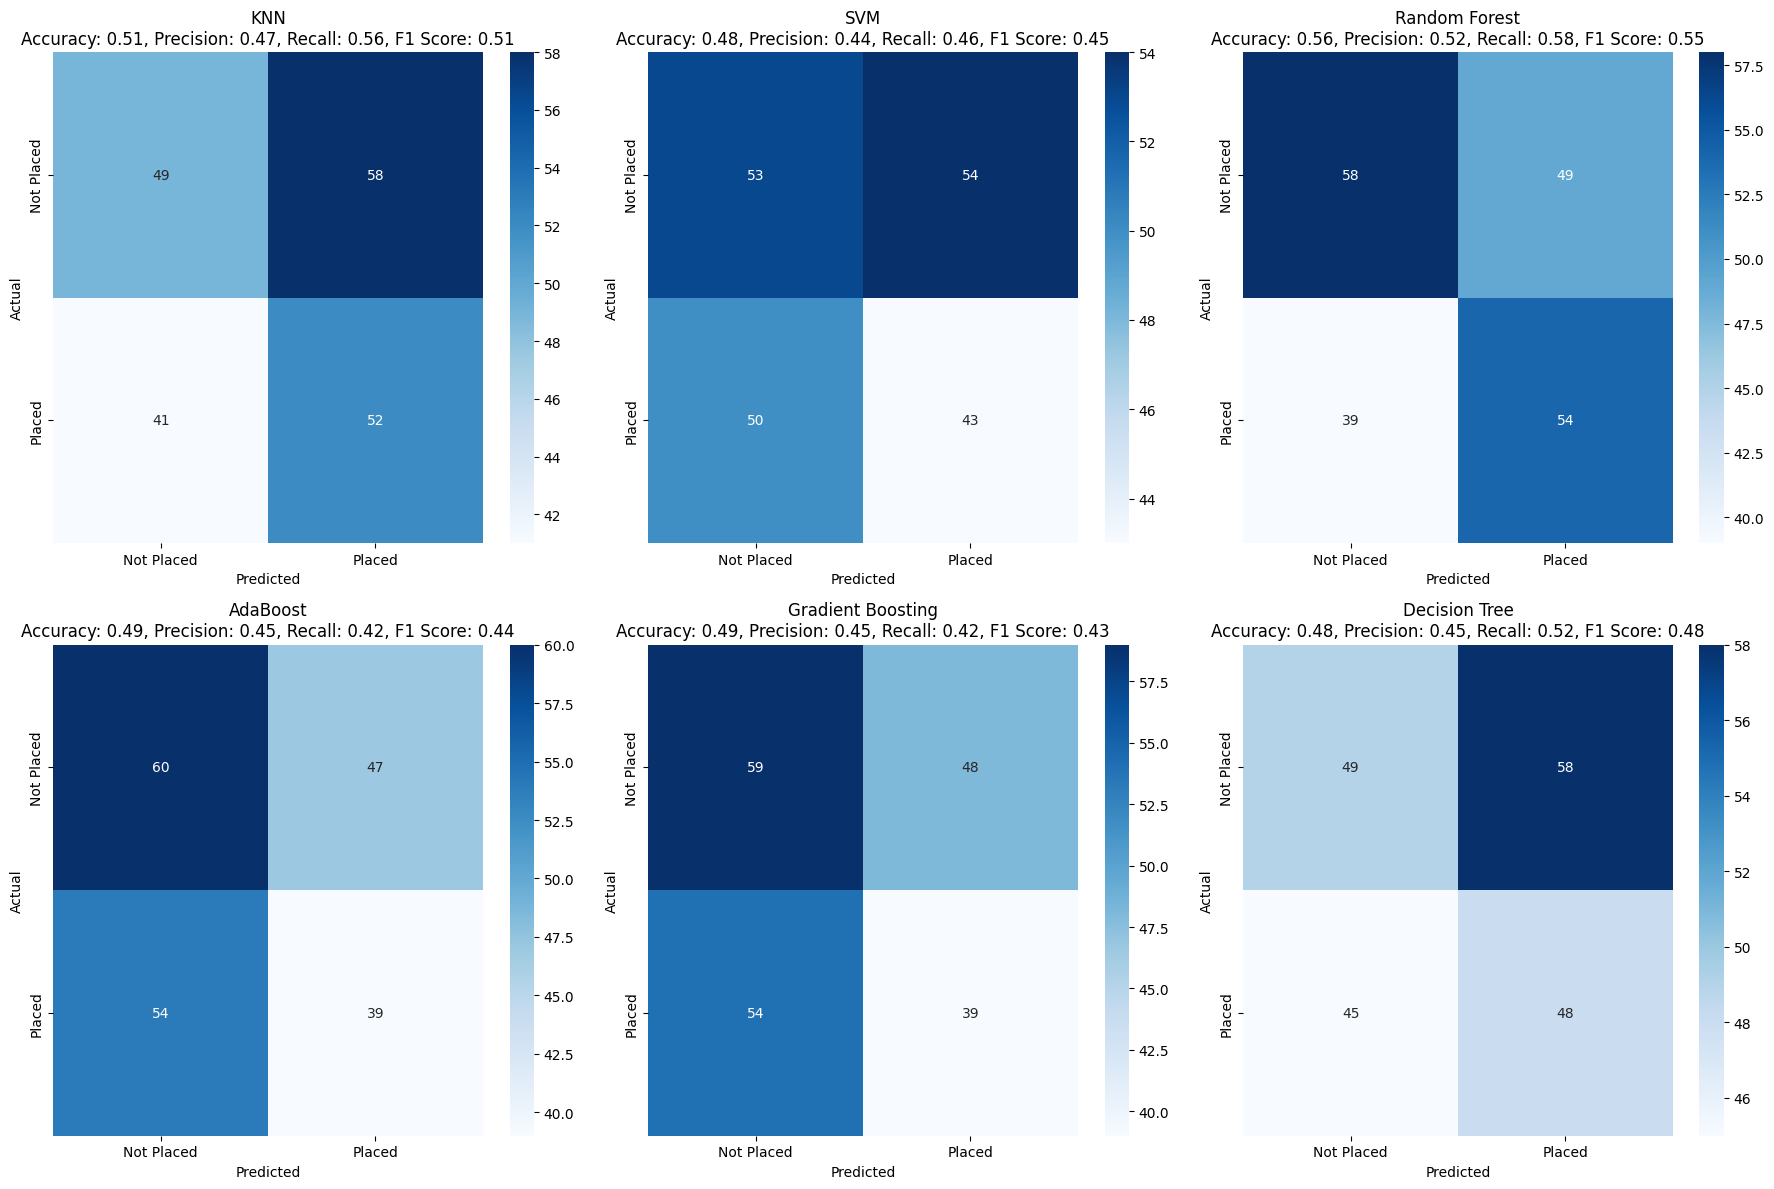

In [56]:
# Инициализация моделей
models = {
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

# Обучение моделей
for name, model in models.items():
    model.fit(X_train, y_train)

# Вычисление матриц ошибок для каждой модели
confusion_matrices = {name: confusion_matrix(y_test, model.predict(X_test)) for name, model in models.items()}

# Инициализация списка метрик
metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1 Score": f1_score
}

# Вычисление метрик для каждой модели
model_metrics = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    model_metrics[name] = {metric_name: metric(y_test, y_pred) for metric_name, metric in metrics.items()}

# Визуализация матриц ошибок с добавлением метрик в заголовок и подписей осей
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
for ax, (name, matrix) in zip(axes.flatten(), confusion_matrices.items()):
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g', ax=ax, cbar=True)
    ax.set_title(f"{name}\n" +
                 f"Accuracy: {model_metrics[name]['Accuracy']:.2f}, " +
                 f"Precision: {model_metrics[name]['Precision']:.2f}, " +
                 f"Recall: {model_metrics[name]['Recall']:.2f}, " +
                 f"F1 Score: {model_metrics[name]['F1 Score']:.2f}")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(['Not Placed', 'Placed'])
    ax.set_yticklabels(['Not Placed', 'Placed'])

plt.tight_layout()
plt.show()

Ужасно - наилучший результат показала модель случайного леса, ну возможно потому что она построила несколько вариантов разбиения и выбрала самый лучший

Теперь запустим этот же код но уже будем учить и предсказывать на всей выборке

In [57]:
# Разделение данных на признаки (X) и целевую переменную (y)
X_train = df3[['cgpa', 'placement_exam_marks']]
y_train = df3['placed']


print("Размер обучающего набора:", X_train.shape)
print("Размер тестового набора:", y_train.shape)

Размер обучающего набора: (1000, 2)
Размер тестового набора: (1000,)


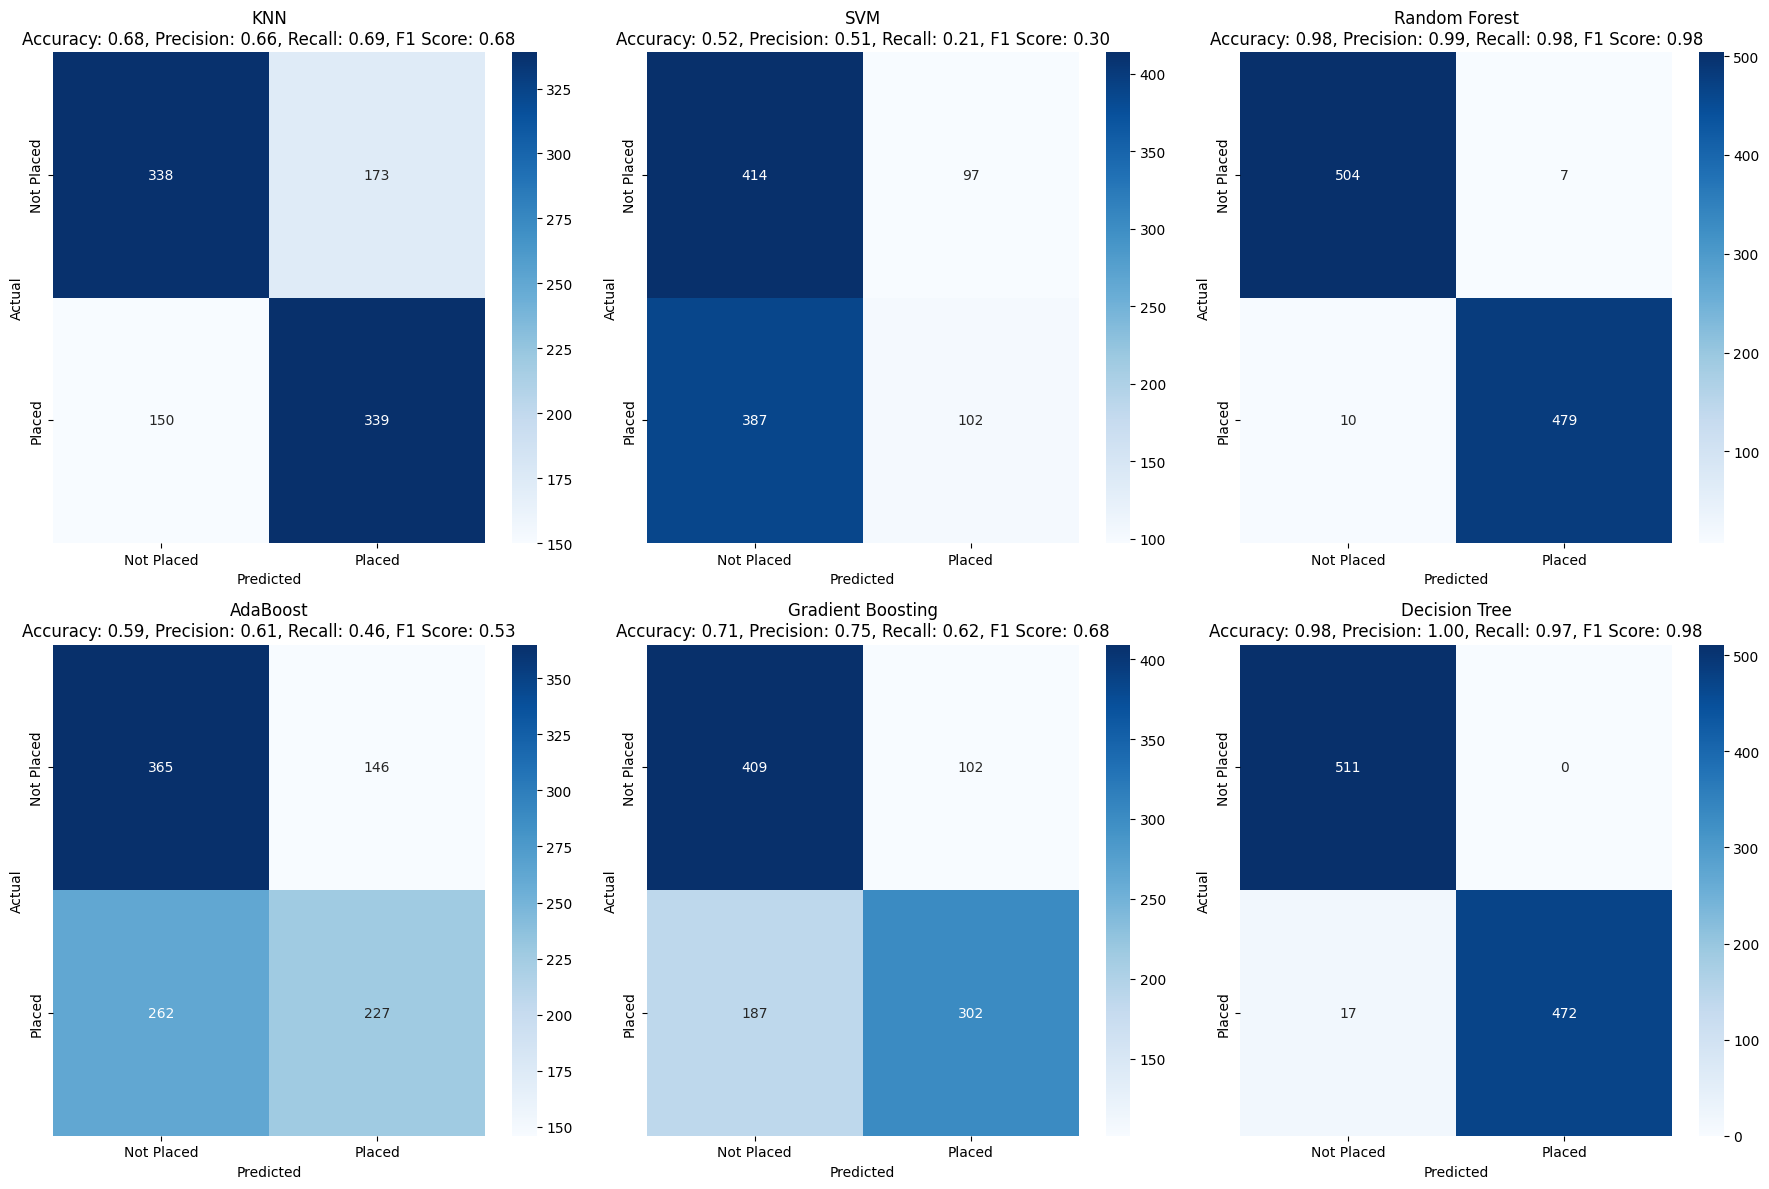

In [58]:
# Инициализация моделей
models = {
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

# Обучение моделей
for name, model in models.items():
    model.fit(X_train, y_train)

# Вычисление матриц ошибок для каждой модели
confusion_matrices = {name: confusion_matrix(y_train, model.predict(X_train)) for name, model in models.items()}

# Инициализация списка метрик
metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1 Score": f1_score
}

# Вычисление метрик для каждой модели
model_metrics = {}
for name, model in models.items():
    y_pred = model.predict(X_train)
    model_metrics[name] = {metric_name: metric(y_train, y_pred) for metric_name, metric in metrics.items()}

# Визуализация матриц ошибок с добавлением метрик в заголовок и подписей осей
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
for ax, (name, matrix) in zip(axes.flatten(), confusion_matrices.items()):
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g', ax=ax, cbar=True)
    ax.set_title(f"{name}\n" +
                 f"Accuracy: {model_metrics[name]['Accuracy']:.2f}, " +
                 f"Precision: {model_metrics[name]['Precision']:.2f}, " +
                 f"Recall: {model_metrics[name]['Recall']:.2f}, " +
                 f"F1 Score: {model_metrics[name]['F1 Score']:.2f}")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(['Not Placed', 'Placed'])
    ax.set_yticklabels(['Not Placed', 'Placed'])

plt.tight_layout()
plt.show()

Обратите внимание на деревья!!! Да в части обобщения логики мы видим что они были в топе, но метрики были не очень, но в части познания логики конкретного набора данных они ее схватывают, делают ветки и листья и дробят но понимают логику. НО еще раз повторбсь многочисленные эксперименты на случайно генерируемых датасетах показали, что с обобщениями и деревья справляются не очень, но их можно кидать на неразмеченные данные и они их разобьют практически так же хорошо как и размеченные и вот эту особенность стоит иметь ввиду и использовать (и я использую, потому что диплом очень связан с аномалиями)